# Pytorch Datasets and Dataloaders

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fill in the ... part with the path to the planet dataset folder in your google drive. 

In [ ]:
%%shell

cp -r '/content/drive/MyDrive/ML201+/Participants Folder/Datasets/Planet/' .
cp -r Planet/* .
unzip train.zip

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms
from torch import Tensor
from collections import Counter
from pandas import DataFrame
from math import ceil
import random 
import numpy as np
import torch 
import pandas as pd 
import os

We need to explore the dataset first before we do anything related with pytorch. If we look at what has been loaded, we have a train.csv, train folder and test folder. 

In many Machine Learning and Deep Learning problems, extensive EDA and feature engineering at the start is not required. However, there are still some basic things to look out for. These include:

1) Is this a classification or regression problem? (i.e. is the value to be predicted discrete or continuous)

2) Format of labels (are they strings, integers, do they need to be one hot encoded?)

3) What are the rough proportion of labels to be predicted in relation to one another if this is a classification problem?

4) What are the sizes of the train and test datasets respectively?

5) What does the train.csv contain?

Explore the dataset for the next 3-5 minutes and see if you can answer these questions:

In [9]:
# Explore the dataset here
train_csv = pd.read_csv('train.csv')
train_csv.head()

,image_name,tags
0,train_16730,clear primary
1,train_35525,cloudy
2,train_11352,cloudy
3,train_2918,agriculture clear primary road
4,train_6410,clear primary


There are always 2 stages in the data preparation part when using pytorch: datasets and dataloaders. 

All pytorch datasets (whatever sort of dataset you want to create, that is) is a child class of the generic torch.utils.data.Dataset class. So to create a custom dataset class of our own, we need to **inherit** from this pytorch generic dataset class. 

https://pytorch.org/docs/stable/data.html

Additionally, every dataset class must implement minimally the following 2 methods: dunder_len and dunder_getitem. The former implements the functionality of finding out the size of your dataset using the len() method, while the latter implements the functionality of indexing into your dataset as how you would index a list.

In [13]:
# ToTensor converts the numpy array to a torch Tensor of the same data type
class ToTensor(object):
    
  def __call__(self, x: np.ndarray) -> Tensor:
    return torch.Tensor(x)

# NormalizeStandardize first normalizes the input by scaling between 0 and 1
# Then it standardizes the inputs by some given mean and std dev stats
# Lastly it reshapes the numpy array to be channels first, i.e. C X H X W
class NormalizeStandardize(object):

  def __init__(self, mean: list, std: list):
    self.mean = np.array(mean)
    self.std = np.array(std)

  def __call__(self, x: np.ndarray) -> np.ndarray:
    normalized = np.true_divide(x, 255.0)
    standardized = np.true_divide((normalized - self.mean), self.std)
    return np.transpose(standardized, axes=(2, 0, 1))

# Applies each transformation iteratively on the input
class Compose(object):

  def __init__(self, transforms: list):
    self.transforms = transforms

  def __call__(self, x: np.ndarray) -> Tensor:
    for t in self.transforms:
      x = t(x)
    return x

In [14]:
class PlanetDataset(Dataset):
    
    def __init__(self, csv_file: str,
                 img_dir: str, mapping: dict,
                 x_transforms: list=[],
                 y_transforms: list=[]):
        self.mapping = mapping
        self.labels = self.transform_labels(pd.read_csv(csv_file))
        self.img_dir = img_dir
        self.mean, self.std = self.calc_stats()
        x_transforms.extend([NormalizeStandardize(self.mean, self.std),
                                                         ToTensor()])
        y_transforms.append(ToTensor())
        self.x_transforms = Compose(x_transforms)
        self.y_transforms = Compose(y_transforms)

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx: int):
        img = f"{self.img_dir}/{self.labels.iloc[idx, 0]}.jpg"
        img_array = np.array(Image.open(img).convert('RGB'))
        label = self.labels.iloc[idx, 2]
        
        img_array = self.x_transforms(img_array)
        label = self.y_transforms(label)
            
        return img_array, label
    
    def visualize_images(self, num_images: int=5):
        random_selection = np.random.choice(list(self.labels['image_name']), num_images)
        cols = 1
        rows = num_images
        fig = plt.figure(figsize=(6, 6*num_images))
        for i in range(1, rows+1):
            img = f"{self.img_dir}/{random_selection[i-1]}.jpg"
            img_array = np.array(Image.open(img).convert('RGB'))
            fig.add_subplot(rows, cols, i)
            plt.axis('off')
            plt.title(f"{self.labels.loc[self.labels['image_name']==random_selection[i-1], 'tags'].iloc[0]}")
            plt.imshow(img_array)
        fig.tight_layout()
        plt.show()

    def calc_stats(self):
      image_list = os.listdir(self.img_dir)
      images = np.true_divide(np.stack([np.array(Image.open(os.path.join(self.img_dir, img)).convert('RGB')) for img in image_list]), 255.0)
      mean = np.mean(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      std = np.std(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      return mean, std

    def transform_labels(self, df: DataFrame):
      df['labels'] = df['tags'].apply(lambda x: self._one_hot_encode(x))
      return df

    def _one_hot_encode(self, labels: str):
      labels = labels.split(' ')
      encoding = np.zeros(len(self.mapping.keys()))
      for label in labels:
        encoding[self.mapping[label]] = 1
      return encoding

We need to remember that the labels in the train.csv are in text format, so below are some handy processing functions to create their mappings to integers.

In [15]:
def count_labels(csv_file: str):
  c = Counter()
  train_csv = pd.read_csv(csv_file)
  for i in range(len(train_csv)):
    tags = train_csv['tags'][i].split(' ')
    for l in tags:
      c[l] += 1
  return c, list(c.keys())

def create_mapping(keys):
  return {key : i for i, key in enumerate(keys)}

c, keys = count_labels('train.csv')
mapping = create_mapping(keys)

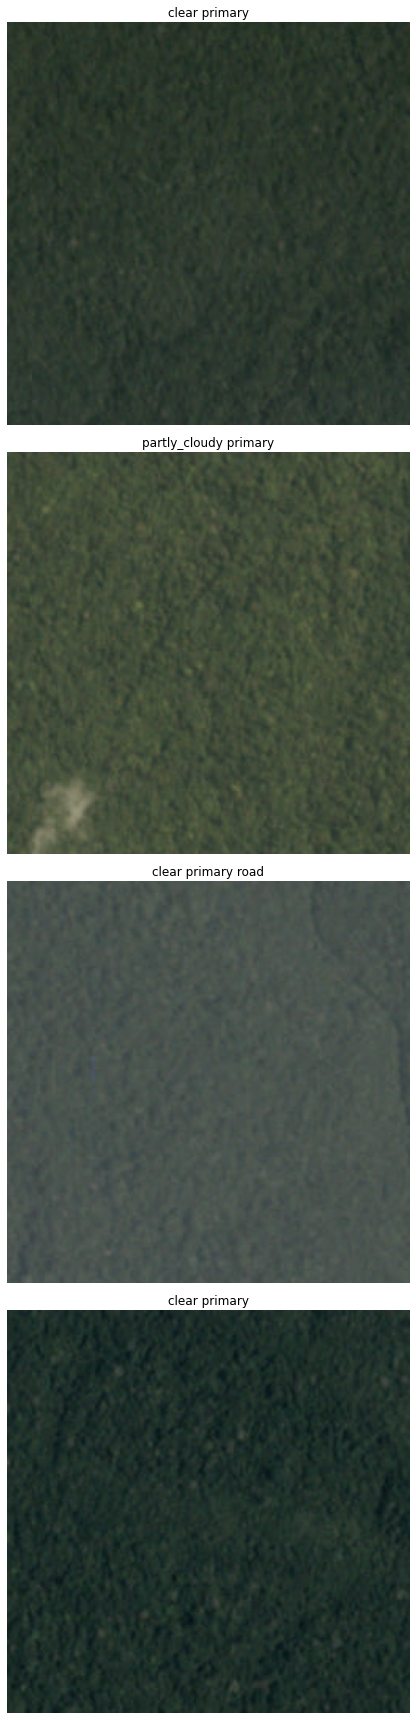

In [16]:
ds = PlanetDataset(csv_file='train.csv',
                   img_dir='train',
                   mapping=mapping)

ds.visualize_images(4)

In [17]:
def train_val_split(dataset: Dataset, train_split: float):
  train_size = ceil(train_split * len(dataset))
  valid_size = len(dataset) - train_size
  train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
  return train_ds, valid_ds

train_ds, valid_ds = train_val_split(ds, 0.8)

Ok, so we're done creating the train and validation datasets...or are we?


Let's refactor our dataset class a little bit. 

In [18]:
class PlanetDatasetReformatted(Dataset):
    
    def __init__(self, labels_df: DataFrame,
                 img_dir: str,
                 x_transforms: list=[],
                 y_transforms: list=[],
                 stats: tuple=(None, None)):
        self.mapping = mapping
        self.labels_df = labels_df
        self.img_dir = img_dir
        self.mean, self.std = stats[0], stats[1]
        self.x_transforms, self.y_transforms = self.make_transform(x_transforms, y_transforms)
        
    def __len__(self):
        return len(self.labels_df)
        
    def __getitem__(self, idx: int):
        img = f"{self.img_dir}/{self.labels_df.iloc[idx, 0]}.jpg"
        img_array = np.array(Image.open(img).convert('RGB'))
        label = self.labels_df.iloc[idx, 2]
        img_array = self.x_transforms(img_array)
        label = self.y_transforms(label)
            
        return img_array, label
    
    def visualize_images(self, num_images: int=5):
        random_selection = np.random.choice(list(self.labels['image_name']), num_images)
        cols = 1
        rows = num_images
        fig = plt.figure(figsize=(6, 6*num_images))
        for i in range(1, rows+1):
            img = f"{self.img_dir}/{random_selection[i-1]}.jpg"
            img_array = np.array(Image.open(img).convert('RGB'))
            fig.add_subplot(rows, cols, i)
            plt.axis('off')
            plt.title(f"{self.labels_df.loc[self.labels_df['image_name']==random_selection[i-1], 'tags'].iloc[0]}")
            plt.imshow(img_array)
        fig.tight_layout()
        plt.show()

    def make_transform(self, x_transforms, y_transforms):
      if self.mean is None and self.std is None:
        self.mean, self.std = self.calc_stats()
      x_transforms.extend([NormalizeStandardize(self.mean, self.std),
                                                        ToTensor()])
      y_transforms.append(ToTensor())
      return Compose(x_transforms), Compose(y_transforms)
 
    def calc_stats(self):
      image_list = list(self.labels_df['image_name'])
      images = np.true_divide(np.stack([np.array(Image.open(os.path.join(self.img_dir, img + '.jpg')).convert('RGB')) for img in image_list]), 255.0)
      mean = np.mean(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      std = np.std(images, axis=(0, 1, 2)).reshape(1, 1, -1)
      return mean, std

    def get_stats(self):
      return self.mean, self.std


In [19]:
def transform_labels(mapping: dict, df: DataFrame):
  df['labels'] = df['tags'].apply(lambda x: one_hot_encode(mapping, x))
  return df

def one_hot_encode(mapping: dict, labels: str):
  labels = labels.split(' ')
  encoding = np.zeros(len(mapping.keys()))
  for label in labels:
    encoding[mapping[label]] = 1
  return encoding

def train_val_split(csv_file: str,
                    img_dir: str,
                    mapping: dict,
                    seed: int,
                    train_split: float,
                    x_transforms: list=[],
                    y_transforms: list=[]):
  
  random.seed(seed)
  label_df = transform_labels(mapping, pd.read_csv(csv_file))
  label_df = label_df.sample(frac=1, random_state=seed).reset_index(drop=True)
  train_size = ceil(train_split * len(label_df))
  train_df, valid_df = label_df.iloc[:train_size], label_df.iloc[train_size:]
  train_ds = PlanetDatasetReformatted(labels_df=train_df,
                                      img_dir=img_dir,
                                      x_transforms=list(x_transforms),
                                      y_transforms=list(y_transforms))
  
  train_stats = train_ds.get_stats()
  valid_ds = PlanetDatasetReformatted(labels_df=valid_df,
                                      img_dir=img_dir,
                                      x_transforms=list(x_transforms),
                                      y_transforms=list(y_transforms),
                                      stats=train_stats)
  
  return train_ds, valid_ds

In [20]:
train_ds, valid_ds = train_val_split(csv_file='train.csv',
                                     img_dir='train',
                                     mapping=mapping,
                                     seed=42,
                                     train_split=0.8)

img, label = train_ds[0]
print(img.shape, label.shape)

torch.Size([3, 256, 256]) torch.Size([17])


And now we're finally ready to move on to creating the dataloaders. 

In [21]:
train_dl = DataLoader(train_ds, batch_size=16,
                      shuffle=True, num_workers=4)
                      
valid_dl = DataLoader(valid_ds, batch_size=8,
                      shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


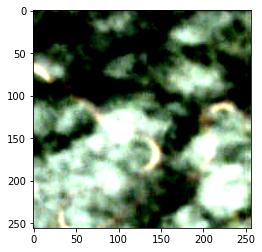

In [22]:
image, labels = next(iter(train_dl))
plt.imshow(image[0].permute(1, 2, 0))

# Model Instantiation

# Loss Function

# Optimizer

# Debugging and Unit Testing

# Training and Evaluation

# Logging and Visualization